# *Visual Transformers*

En este cuadernillo se aplicara ViT para la clasificacion de imagenes

## Dataset

In [59]:
import pytorch_lightning as pl
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import pandas as pd
from tensorflow import keras
import math
import random

In [60]:
class ImageDataModule(pl.LightningDataModule):
    def __init__(self, root_dir: str = r'C:\Users\micky\Downloads\Telegram Desktop\dogs_dataset', batch_size: int = 64, img_size: tuple = (50, 50), val_split: float = 0.2, seed: int = 42, dataset_class=None):
        super().__init__()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.val_split = val_split
        self.seed = seed
        self.dataset_class = dataset_class  # Add a parameter for dataset class

        # Define transformations
        self.transforms = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
        ])

    def setup(self, stage=None):
    # Load the dataset
        full_dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transforms)
    
    # Calculate the number of samples for validation
        num_samples = len(full_dataset)
        val_size = int(self.val_split * num_samples)
        train_size = num_samples - val_size
    
    # Split the dataset into training and validation sets
        train_ds, val_ds = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(self.seed))
    
    # Use the provided dataset class to initialize datasets
        if self.dataset_class is not None:
        # Extract the images and labels from the subsets
            train_images, train_labels = zip(*[(image, label) for image, label in train_ds])
            val_images, val_labels = zip(*[(image, label) for image, label in val_ds])
        
        # Initialize the AttnDataset with the images and labels
            self.train_ds = self.dataset_class(train_images, train_labels, self.transforms)
            self.val_ds = self.dataset_class(val_images, val_labels, self.transforms)
        else:
            self.train_ds = train_ds
            self.val_ds = val_ds


    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False)


In [61]:
dm = ImageDataModule()
dm.setup()

In [62]:
next(iter(dm.train_dataloader()))

[tensor([[[[0.7176, 0.7843, 0.7882,  ..., 0.6510, 0.8039, 0.8549],
           [0.7333, 0.7961, 0.7922,  ..., 0.6863, 0.8235, 0.8706],
           [0.7294, 0.7961, 0.7922,  ..., 0.7294, 0.8471, 0.8902],
           ...,
           [0.8902, 0.9216, 0.9098,  ..., 0.9333, 0.9294, 0.9294],
           [0.8863, 0.8902, 0.8824,  ..., 0.9176, 0.9255, 0.9255],
           [0.8824, 0.8863, 0.8824,  ..., 0.9176, 0.9255, 0.9255]],
 
          [[0.3294, 0.3961, 0.4000,  ..., 0.4196, 0.6941, 0.7451],
           [0.3451, 0.4078, 0.4039,  ..., 0.4314, 0.7059, 0.7529],
           [0.3412, 0.4078, 0.4039,  ..., 0.4392, 0.7137, 0.7569],
           ...,
           [0.8196, 0.8510, 0.8392,  ..., 0.8588, 0.8667, 0.8667],
           [0.8275, 0.8314, 0.8235,  ..., 0.8549, 0.8588, 0.8588],
           [0.8235, 0.8275, 0.8235,  ..., 0.8549, 0.8588, 0.8588]],
 
          [[0.2039, 0.2706, 0.2745,  ..., 0.4039, 0.7412, 0.7922],
           [0.2196, 0.2824, 0.2784,  ..., 0.4157, 0.7529, 0.8000],
           [0.2196, 0.28

In [63]:
next(iter(dm.val_dataloader()))

[tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 0.9804, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000]],
 
          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 0.9804, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000]],
 
          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.00

In [64]:
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 3, 50, 50]), torch.Size([64]))

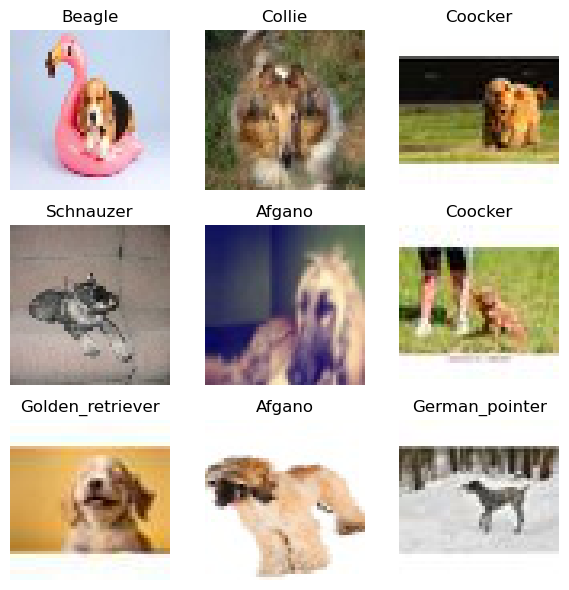

In [65]:
class_to_idx = dm.train_ds.dataset.class_to_idx

idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}

r, c = 3, 3
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(idx_to_class[label.item()])

        ax.axis("off")
plt.tight_layout()
plt.show()

## El modelo

Empezamos con la implementación del *patch embedding*. Este módulo recibirá un batch de imágenes y se encargará de proyectar los diferentes *patches*. Para ello podemos usar una capa convolucional con un tamaño de *kernel* y *stride* iguales al tamaño del *patch* que queramos usar.

In [66]:
import torch.nn as nn

# https://github.com/jankrepl/mildlyoverfitted/blob/master/github_adventures/vision_transformer/custom.py

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

In [67]:
pe = PatchEmbedding(img_size=50, patch_size=7, in_chans=3, embed_dim=100)
out = pe(imgs)
out.shape

torch.Size([64, 49, 100])

Una vez tenemos nuestros datos proyectados, podemos dárselos a nuestro transformer encoder para que haga su magia.

In [68]:
import math

class MultiHeadAttention(nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads

        # key, query, value projections
        self.key = nn.Linear(n_embd, n_embd*n_heads)
        self.query = nn.Linear(n_embd, n_embd*n_heads)
        self.value = nn.Linear(n_embd, n_embd*n_heads)

        # output projection
        self.proj = nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)

        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side

        return self.proj(y)

In [69]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

Siguiendo el trabajo de los autores originales, ya solo nos faltaría añadir el token `class` y los *postitional embeddings*. En implementaciones anteriores conectábamos la salida del transformer a un clasificador lineal para darnos el resultado final. En *ViT*, sin embargo, se utiliza un token especial al principio de la secuencia, al cual conectamos nuestro clasificador final.

In [70]:
class ViT(nn.Module):

    def __init__(self, img_size=50, patch_size=7, in_chans=3, embed_dim=100, n_heads=3, n_layers=3, n_classes=9):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))

        self.tranformer = torch.nn.Sequential(*[TransformerBlock(embed_dim, n_heads) for _ in range(n_layers)])

        self.ln = nn.LayerNorm(embed_dim)
        self.fc = torch.nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        e = self.patch_embed(x)
        B, L, E = e.size()

        cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, E)
        e = torch.cat((cls_token, e), dim=1)  # (B, 1 + N, E)
        e = e + self.pos_embed  # (B, 1 + N, E)

        z = self.tranformer(e)

        cls_token_final = z[:, 0]
        y = self.fc(cls_token_final)

        return y

In [71]:
vit = ViT(in_chans=3)
out = vit(imgs)
out.shape

torch.Size([64, 9])

In [72]:
class Model(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.vit = ViT()

    def forward(self, x):
        return self.vit(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)

    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        return optimizer

In [73]:
model = Model()
out = model(imgs)
out.shape

torch.Size([64, 9])

In [75]:
model = Model()
trainer = pl.Trainer(max_epochs=5, accelerator='gpu', logger=None)
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\micky\Downloads\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | vit  | ViT  | 626 K 
------------------------------
626 K     Trainable params
0         Non-trainable params
626 K     Total params
2.507     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\micky\.conda\envs\InteligenciArtificial\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


C:\Users\micky\.conda\envs\InteligenciArtificial\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 585/585 [01:07<00:00,  8.62it/s, v_num=0, acc=0.344]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 585/585 [00:31<00:00, 18.32it/s, v_num=0, acc=0.562, val_loss=1.490, val_acc=0.457]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 585/585 [00:34<00:00, 17.01it/s, v_num=0, acc=0.562, val_loss=1.330, val_acc=0.521]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 585/585 [00:32<00:00, 17.94it/s, v_num=0, acc=0.578, val_loss=1.250, val_acc=0.559]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 585/585 [00:32<00:00, 17.90it/s, v_num=0, acc=0.719, val_loss=1.150, val_acc=0.599]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 585/585 [00:39<00:00, 14.92it/s, v_num=0, acc=0.719, val_loss=1.100, val_acc=0.619]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 585/585 [00:39<00:00, 14.90it/s, v_num=0, acc=0.719, val_loss=1.100, val_acc=0.619]


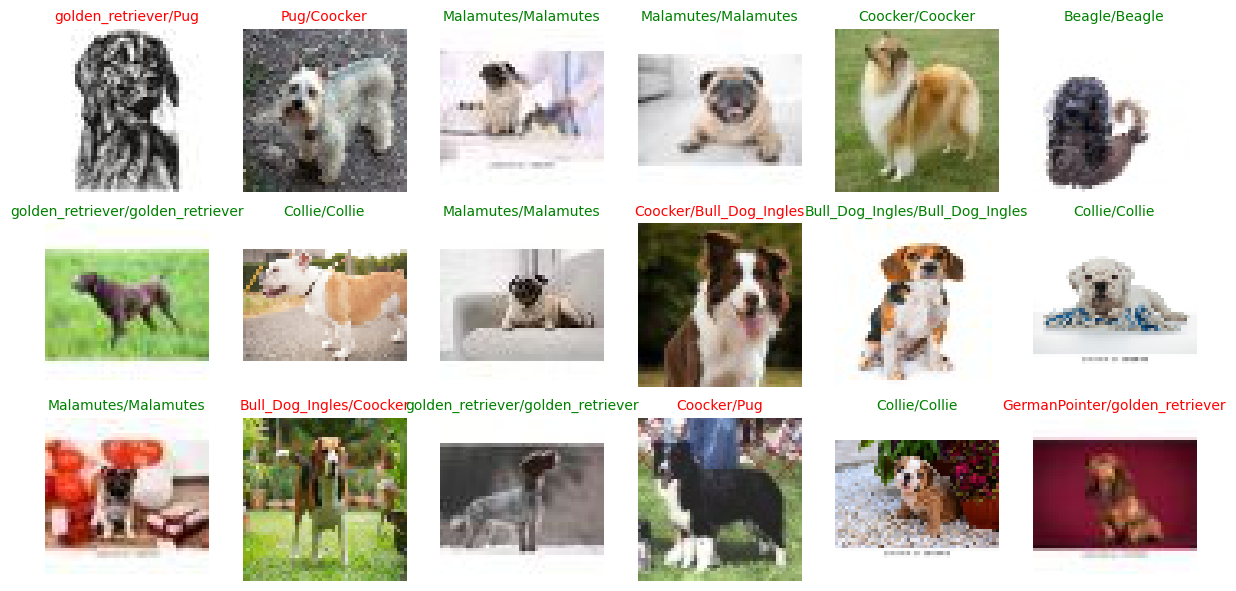

In [91]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = model.predict(imgs)

class_names = [
    'Beagle',
    'Bull_Dog_Ingles',
    'Collie',
    'Coocker',
    'GermanPointer',
    'golden_retriever',
    'hound',
    'Malamutes',
    'Pug',
    'saint_bernard',
    'Schnauzer',
    'siberian_husky'
]
font_size = 10


r, c = 3, 6
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img.permute(1, 2, 0))
        true_class = class_names[label.item()]
        pred_class = class_names[preds[ix].item()]
        ax.set_title(
            f'{true_class}/{pred_class}',
            color="green" if label == preds[ix] else 'red',
            fontsize=font_size
        )
        ax.axis("off")
plt.tight_layout()
plt.show()


Si bien nuestra implementación es funcional, podemos utilizar otras que ya existan para asegurarnos que todo está bien implementado y optimizado. Una solución recomendable es usar la librería [timm](https://github.com/rwightman/pytorch-image-models).

In [82]:
from timm.models.vision_transformer import VisionTransformer

# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py

class Model2(Model):
    def __init__(self):
        super().__init__()
        self.vit = VisionTransformer(
            img_size=50,
            patch_size=7,
            in_chans=3,
            num_classes=9,
            embed_dim=100,
            depth=3,
            num_heads=2
        )

C:\Users\micky\.conda\envs\InteligenciArtificial\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [83]:
model2 = Model2()
out = model2(imgs)
out.shape

torch.Size([64, 9])

In [85]:
model2 = Model2()
trainer = pl.Trainer(max_epochs=5, accelerator='gpu', precision=16, logger=None)
trainer.fit(model2, dm)

C:\Users\micky\.conda\envs\InteligenciArtificial\Lib\site-packages\lightning_fabric\connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type              | Params
-------------------------------------------
0 | vit  | VisionTransformer | 384 K 
-------------------------------------------
384 K     Trainable params
0         Non-trainable params
384 K     Total params
1.540     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\micky\.conda\envs\InteligenciArtificial\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\micky\.conda\envs\InteligenciArtificial\Lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


C:\Users\micky\.conda\envs\InteligenciArtificial\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 585/585 [02:41<00:00,  3.63it/s, v_num=1, acc=0.453]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 585/585 [02:13<00:00,  4.38it/s, v_num=1, acc=0.562, val_loss=1.680, val_acc=0.393]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 585/585 [01:53<00:00,  5.16it/s, v_num=1, acc=0.656, val_loss=1.330, val_acc=0.529]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 585/585 [01:44<00:00,  5.59it/s, v_num=1, acc=0.609, val_loss=1.180, val_acc=0.581]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 585/585 [01:28<00:00,  6.59it/s, v_num=1, acc=0.594, val_loss=1.100, val_acc=0.607]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 585/585 [01:48<00:00,  5.39it/s, v_num=1, acc=0.594, val_loss=1.040, val_acc=0.627]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 585/585 [01:48<00:00,  5.38it/s, v_num=1, acc=0.594, val_loss=1.040, val_acc=0.627]


En este caso la diferencia en número de parámetros y precisión se debe a que, en la implementació original del *Transformer*, el cálculo de las *keys*, *queries* y *values* se divide entre las diferentes cabezas, mientras que en nuestra implementación (debido a la baja dimensionalidad del problema) las estamos multiplicando.